In [802]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


In [803]:
#load and take a look at the dataset
df = pd.read_csv('SfLibrary/Library_Usage.csv');
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [804]:
df.shape

(423448, 15)

In [805]:
#Notice a couple of things:
#The data set does not include yearly active, just most recent year active. It also does not have what type of reader 
#the patron might be, which I would think would have an impact on whether the renew and/or check out more books.
#This is a bummer, but we must go on.
#Some things I do see: total check outs, total renewals (but not per checkout), age range, and home library
#All of the above is intresting information that may help in predicting some attribute about a patron.


In [806]:
#First, let's do some data clean up
#I noticed the headers of all columns include spaces, I want to get rid of this as it makes it harder to call columns
df.rename(columns = lambda x: '_'.join(x.split()), inplace = True)
df.head()

,Patron_Type_Code,Patron_Type_Definition,Total_Checkouts,Total_Renewals,Age_Range,Home_Library_Code,Home_Library_Definition,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference_Code,Notice_Preference_Definition,Provided_Email_Address,Year_Patron_Registered,Outside_of_County,Supervisor_District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [807]:
df.rename(columns = {"Patron_Type_Definition":"Patron_Type", "Home_Library_Definition":"Library", "Notice_Preference_Definition":"Notice_Preference"},inplace = True)

In [808]:
#I also notice some duplicate columns, such as Home_Library_Code and Home_Library_Definition. I don't really want to
#keep the code so I'll just keep the definitions. I also notice that the data for Supervisor District is not in the file,
#so I'll go ahead and drop that column as well

df.drop(['Patron_Type_Code','Home_Library_Code','Notice_Preference_Code', 'Supervisor_District'], axis =1,inplace = True)
df.head()


,Patron_Type,Total_Checkouts,Total_Renewals,Age_Range,Library,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference,Provided_Email_Address,Year_Patron_Registered,Outside_of_County
0,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True
1,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False
2,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True
3,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False
4,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False


In [809]:
#next, let's look at the current datatypes of each column and see if this lines up with how I want to use the data
df.dtypes

Patron_Type                 object
Total_Checkouts              int64
Total_Renewals               int64
Age_Range                   object
Library                     object
Circulation_Active_Month    object
Circulation_Active_Year     object
Notice_Preference           object
Provided_Email_Address        bool
Year_Patron_Registered       int64
Outside_of_County             bool
dtype: object

In [810]:
#from the above error, I can see that 'None' is one of the entries in the column.
#To determine how to replace this data, I want to see what percentage of the rows have a circulation value of 'None'
((df[df.Circulation_Active_Year == 'None'].Circulation_Active_Year.count())/df.shape[0])*100


16.035971358938998

In [811]:
#Hmm 16% is quite a large percentage of the data set, so I don't think I want to completly delete these out of my data
#Instead, to allow for casting as an integer, I will replace None with 0, an non-sensical year that is easy to spot in
#the data
df['Circulation_Active_Year'] = np.where(df['Circulation_Active_Year'] == 'None', df['Year_Patron_Registered'], df['Circulation_Active_Year'])


In [812]:
df.Circulation_Active_Year= df.Circulation_Active_Year.astype(int, copy = False)

In [813]:
df.dtypes

Patron_Type                 object
Total_Checkouts              int64
Total_Renewals               int64
Age_Range                   object
Library                     object
Circulation_Active_Month    object
Circulation_Active_Year      int64
Notice_Preference           object
Provided_Email_Address        bool
Year_Patron_Registered       int64
Outside_of_County             bool
dtype: object

In [814]:
#Now that all data types look OK, let's move on to missing/null values
df[df.isnull()== True].count()


Patron_Type                 0
Total_Checkouts             0
Total_Renewals              0
Age_Range                   0
Library                     0
Circulation_Active_Month    0
Circulation_Active_Year     0
Notice_Preference           0
Provided_Email_Address      0
Year_Patron_Registered      0
Outside_of_County           0
dtype: int64

In [815]:
#Now that the data looks fairly clean, let's take a second look and ask some questions!
df.describe()

,Total_Checkouts,Total_Renewals,Circulation_Active_Year,Year_Patron_Registered
count,423448.000000,423448.000000,423448.000000,423448.000000
mean,161.982097,59.657327,2014.612873,2010.348917
std,453.703678,225.009917,1.629805,4.357374
min,0.000000,0.000000,2003.000000,2003.000000
25%,2.000000,0.000000,2014.000000,2007.000000
50%,19.000000,2.000000,2015.000000,2012.000000
75%,113.000000,27.000000,2016.000000,2014.000000
max,35907.000000,8965.000000,2016.000000,2016.000000


In [816]:
#Does the number of average total checkouts vary between age_range?
#Does the average yearly checkouts vary between age_range?
# in the above yearly checkout will be calculated by taking the assumed active years
#(Active Year - Year Registered) and dividing checkouts by this number 
#Does the average total renewals to total checkouts ratio = renewal rate vary between age_range?
#Do supervisor districts have any effect on the above trends?
#Can I predict a users  approx. renewal rate base on age_range and district?

#Additional Questions from a business standpoint:
#Which age group has the largest average retention rate, base on year activated and current active year ?
#What is growth like for each age/patron type over 2003-2016?



In [817]:
#Does the number of average total checkouts vary between age_range?
df.groupby('Age_Range').Total_Checkouts.mean().sort_values()
#Looks like 75 and over years has the most check outs average checkouts.
#Though if older patrons have been with the libraries longer, this would may be true just due to time.
#Therefore, average yearly might be a better number for comparison

Age_Range
25 to 34 years        50.472415
20 to 24 years       108.856692
35 to 44 years       110.665351
0 to 9 years         135.988390
45 to 54 years       193.190848
10 to 19 years       236.651042
55 to 59 years       242.424258
60 to 64 years       271.689646
65 to 74 years       294.584519
75 years and over    325.002191
Name: Total_Checkouts, dtype: float64

In [818]:
df['Years_Active'] = df.Circulation_Active_Year - df.Year_Patron_Registered
df.head()

,Patron_Type,Total_Checkouts,Total_Renewals,Age_Range,Library,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference,Provided_Email_Address,Year_Patron_Registered,Outside_of_County,Years_Active
0,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,9
1,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,12
2,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,12
3,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,13
4,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,13


In [819]:
df.groupby('Age_Range').Years_Active.mean().sort_values()

Age_Range
0 to 9 years         2.058496
25 to 34 years       2.560884
20 to 24 years       3.499378
35 to 44 years       4.161092
10 to 19 years       4.867196
45 to 54 years       5.483293
55 to 59 years       5.794489
60 to 64 years       6.007778
65 to 74 years       6.285326
75 years and over    7.266148
Name: Years_Active, dtype: float64

In [820]:
((df.groupby('Age_Range')['Total_Checkouts'].sum())/(df.groupby('Age_Range')['Years_Active'].sum())).sort_values()

Age_Range
25 to 34 years       19.708981
35 to 44 years       26.595266
20 to 24 years       31.107437
45 to 54 years       35.232635
55 to 59 years       41.837039
75 years and over    44.728262
60 to 64 years       45.222985
65 to 74 years       46.868617
10 to 19 years       48.621638
0 to 9 years         66.062016
dtype: float64

In [821]:
#Add another column for renewal rate, the approx. times per checkout that someone has renewed their checkout
df['Renewal_Rate'] = df.Total_Renewals/df.Total_Checkouts
df.head()

,Patron_Type,Total_Checkouts,Total_Renewals,Age_Range,Library,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference,Provided_Email_Address,Year_Patron_Registered,Outside_of_County,Years_Active,Renewal_Rate
0,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,9,0.464286
1,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,12,0.476190
2,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,12,2.032727
3,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,13,0.520548
4,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,13,0.494505


In [822]:
#Are any nulls added with the new column?
df.Renewal_Rate.isnull().sum()


73578

In [823]:
#I assume that the above happens with a person has no checkouts
#and therefore has nothing to renew, resulting in a divided by zero situation
# Now to decide how I want to subsitute this information.
#I want my analysis to only involve "Active" users, which I will define as having at
#least one checkout. Therefore, I will choose to drop all columns that have a renewal rate of null
main_df = df.dropna(subset = ["Renewal_Rate"], axis = 0)
main_df.shape

(349870, 13)

In [824]:
#Which age group has the largest renewal rate?
main_df.groupby('Age_Range').Renewal_Rate.mean().sort_values()
#It's interesting: 25 to 34 years has the largest renewal to checkout rate

Age_Range
10 to 19 years       0.195597
0 to 9 years         0.202195
75 years and over    0.305376
65 to 74 years       0.376149
60 to 64 years       0.417563
20 to 24 years       0.430203
55 to 59 years       0.430741
45 to 54 years       0.442730
35 to 44 years       0.535038
25 to 34 years       0.629715
Name: Renewal_Rate, dtype: float64

In [825]:
#Total Renewals
main_df.groupby('Age_Range').Total_Checkouts.mean().sort_values()
#It seems that the people with more checkouts don't necessarily renew more often, 
#it actually seems like they renew less!
#That may suggest that those who renew more are taking longer to finish the books they check out which leads to
#lower total check outs, this seems most common amongst the middle age groups (25-44)

Age_Range
25 to 34 years        64.872349
35 to 44 years       134.618639
20 to 24 years       137.800255
0 to 9 years         154.165595
45 to 54 years       230.996424
10 to 19 years       270.615741
55 to 59 years       294.515994
60 to 64 years       330.636447
65 to 74 years       358.721396
75 years and over    374.097535
Name: Total_Checkouts, dtype: float64

In [826]:
#the data did not come with the district imported, so I gathered this data and will have to 
#merge it into the main dataset
district_dict = { 'Library':["Parkside", "Ortega", "Richmond", "Anza","Park", "Presidio","Western Edition",
              "Golden Gate Valley", "Marina", "Chinatown", "North Beach", "Mission Bay", "Potrero",
              "Bayview/Linda Brooks-Burton", "Visitacion Valley", "Portola", "Excelsior",
              "Glen Park", "Noe Valley/Sally Brunn", "Mission", "Bernal Heights", "Ingleside",
              "Ocean View", "Merced", "Eureka Valley/Harvey Milk Memorial","Sunset","West Portal", "Main Library",
              "Unknown", "Branch Bookmobile (Excelsior)", "Branch Bookmobile (Marina)",
               "Branch Bookmobile (Sunset)","Branch Bookmobile (West Portal)", "Children's Bookmobile",
               "Library on Wheels"],
                 "District":
              [4,4,1,1,5,2,2,2,2,3,3,6,10,10,10,9,11,8,8,8,9,7,11,7,8,4,7,6,0,0,0,0,0,0,0]}
district_df = pd.DataFrame(data=district_dict)
district_df

,Library,District
0,Parkside,4
1,Ortega,4
2,Richmond,1
3,Anza,1
4,Park,5
5,Presidio,2
6,Western Edition,2
7,Golden Gate Valley,2
8,Marina,2
9,Chinatown,3


In [827]:
#merge into main dataframe
main_df = pd.merge(main_df,district_df, on = "Library", how = "left")

In [828]:
#Check for nulls
main_df[main_df.isnull()== True].count()

Patron_Type                 0
Total_Checkouts             0
Total_Renewals              0
Age_Range                   0
Library                     0
Circulation_Active_Month    0
Circulation_Active_Year     0
Notice_Preference           0
Provided_Email_Address      0
Year_Patron_Registered      0
Outside_of_County           0
Years_Active                0
Renewal_Rate                0
District                    0
dtype: int64

In [847]:
main_df.District= main_df.District.astype(object, copy = False)

In [849]:
main_df.dtypes

Patron_Type                  object
Total_Checkouts               int64
Total_Renewals                int64
Age_Range                    object
Library                      object
Circulation_Active_Month     object
Circulation_Active_Year       int64
Notice_Preference            object
Provided_Email_Address         bool
Year_Patron_Registered        int64
Outside_of_County              bool
Years_Active                  int64
Renewal_Rate                float64
District                     object
dtype: object

In [850]:
#Run same trends across district; Total Average Checkouts 
main_df.groupby('District').Total_Checkouts.mean().sort_values()

District
10.0    143.267005
6.0     146.551459
2.0     152.368075
5.0     169.365231
8.0     174.384436
11.0    183.631432
9.0     209.866860
7.0     226.489267
0.0     233.195848
1.0     251.395936
4.0     270.639365
3.0     317.440858
Name: Total_Checkouts, dtype: float64

In [851]:
#Average Years Active
main_df.groupby('District').Years_Active.mean().sort_values()

District
10.0    4.247095
6.0     4.403074
0.0     4.642561
2.0     4.852872
5.0     4.956223
11.0    5.142999
9.0     5.254008
8.0     5.553686
7.0     5.674304
1.0     5.772582
4.0     5.919574
3.0     6.010947
Name: Years_Active, dtype: float64

In [852]:
#Average yearly check out
((main_df.groupby('District')['Total_Checkouts'].sum())/(main_df.groupby('District')['Years_Active'].sum())).sort_values()

District
2.0     31.397504
8.0     31.399762
6.0     33.283893
10.0    33.732938
5.0     34.172239
11.0    35.705129
7.0     39.914899
9.0     39.944143
1.0     43.549998
4.0     45.719397
0.0     50.230007
3.0     52.810461
dtype: float64

In [853]:
#Average Renewal Rate
main_df.groupby('District').Renewal_Rate.mean().sort_values()

District
10.0    0.275301
11.0    0.280101
0.0     0.281760
9.0     0.303193
3.0     0.381652
8.0     0.399313
4.0     0.408958
7.0     0.413188
2.0     0.421350
1.0     0.430656
5.0     0.457088
6.0     0.523341
Name: Renewal_Rate, dtype: float64

In [954]:
model_df = main_df[['Total_Renewals', 'Total_Checkouts', 'Age_Range',  'Notice_Preference', 'Library', 'District', 'Year_Patron_Registered', 
                   'Patron_Type']]
model_df.head()

,Total_Renewals,Total_Checkouts,Age_Range,Notice_Preference,Library,District,Year_Patron_Registered,Patron_Type
0,13,28,65 to 74 years,email,Main Library,6,2003,SENIOR
1,10,21,55 to 59 years,email,Main Library,6,2003,ADULT
2,559,275,60 to 64 years,email,Main Library,6,2003,ADULT
3,38,73,45 to 54 years,email,Mission Bay,6,2003,ADULT
4,90,182,45 to 54 years,email,Main Library,6,2003,ADULT


In [886]:
#Now to start making a model based on age range, district, and renewal rate
from sklearn.linear_model import LinearRegression

In [955]:
#First create function to create dummy columns for categorical variables
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''

    for col in cat_cols:
        dummy = pd.get_dummies(df[col], prefix = col+"_", dummy_na = dummy_na, drop_first = True)
        df = df.drop(col, axis =1)
        df = pd.concat([df,dummy], axis = 1, join = 'inner')
    
    return df

In [956]:
    cat_cols = model_df.select_dtypes(include = ['object']).columns
    model_df = create_dummy_df(model_df, cat_cols, 0)
    fill_mean = lambda col: col.fillna(col.mean())
 

    model_df = model_df.apply(fill_mean, axis = 0)
    

    X = model_df.drop('Total_Renewals', axis=1)
    y = model_df['Total_Renewals']
    print(model_df.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train,y_train)
    y_test_preds = lm_model.predict(X_test) 
    y_train_preds = lm_model.predict(X_train)
    test_score = r2_score(y_test,y_test_preds)
    train_score = r2_score(y_train,y_train_preds)





(349870, 77)


In [957]:
test_score,train_score

(0.3777896026110268, 0.35135701157865495)

In [947]:
#Overall library registration from 2003 to 2016
plt.plot(df.groupby('Year_Patron_Registered').Total_Renewals.count());

KeyError: 'Year_Patron_Registered'

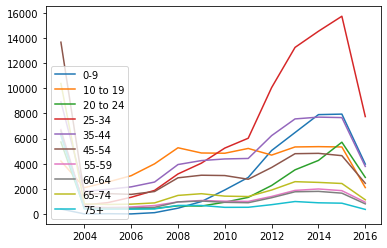

In [748]:
plt.plot(df[df.Age_Range == '0 to 9 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '0-9')
plt.plot(df[df.Age_Range == '10 to 19 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '10 to 19')
plt.plot(df[df.Age_Range == '20 to 24 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '20 to 24')
plt.plot(df[df.Age_Range == '25 to 34 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '25-34')
plt.plot(df[df.Age_Range == '35 to 44 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '35-44')
plt.plot(df[df.Age_Range == '45 to 54 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '45-54')
plt.plot(df[df.Age_Range == '55 to 59 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='55-59')
plt.plot(df[df.Age_Range == '60 to 64 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='60-64')
plt.plot(df[df.Age_Range == '65 to 74 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='65-74')
plt.plot(df[df.Age_Range == '75 years and over'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='75+')
plt.legend(loc='lower left');

In [749]:
df.groupby('Library').Renewal_Rate.mean().sort_values()

Library
Children's Bookmobile                 0.194726
Bayview/Linda Brooks-Burton           0.197242
Visitacion Valley                     0.228024
Branch Bookmobile (West Portal)       0.242267
Portola                               0.271176
Excelsior                             0.273727
Library on Wheels                     0.275752
Ocean View                            0.319169
Unknown                               0.328340
Bernal Heights                        0.332322
Ortega                                0.357243
Mission                               0.366474
Chinatown                             0.373470
Ingleside                             0.381593
Parkside                              0.388529
Branch Bookmobile (Excelsior)         0.397115
North Beach                           0.398534
Marina                                0.401619
West Portal                           0.403918
Glen Park                             0.407057
Potrero                               0.408129
Noe V

In [629]:
df_main = df[df.library == 'North Beach']

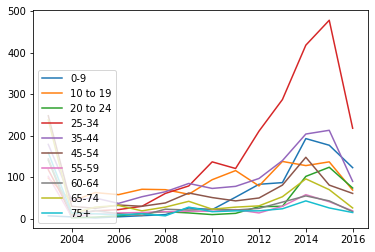

In [630]:
plt.plot(df_main[df_main.Age_Range == '0 to 9 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '0-9')
plt.plot(df_main[df_main.Age_Range == '10 to 19 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '10 to 19')
plt.plot(df_main[df_main.Age_Range == '20 to 24 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '20 to 24')
plt.plot(df_main[df_main.Age_Range == '25 to 34 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '25-34')
plt.plot(df_main[df_main.Age_Range == '35 to 44 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '35-44')
plt.plot(df_main[df_main.Age_Range == '45 to 54 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label = '45-54')
plt.plot(df_main[df_main.Age_Range == '55 to 59 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='55-59')
plt.plot(df_main[df_main.Age_Range == '60 to 64 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='60-64')
plt.plot(df_main[df_main.Age_Range == '65 to 74 years'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='65-74')
plt.plot(df_main[df_main.Age_Range == '75 years and over'].groupby('Year_Patron_Registered').Total_Renewals.count(), label ='75+')
plt.legend(loc='lower left')

In [631]:
#retention rate per year = # of people active in a given year/# of people who joined a year ago
# for 2013 this should be 1 or 0. Start at 2014
(df[(df.Circulation_Active_Year >= 2016) & 
    (df.Year_Patron_Registered == 2015)& 
    (df.Total_Checkouts >0)  ].Total_Renewals.count())/(df[df.Year_Patron_Registered == 2015].Total_Renewals.count())

0.31050397582991973

In [632]:
df[df.Year_Patron_Registered == 2015]


,Patron_Type_Definition,Total_Checkouts,Total_Renewals,Age_Range,Home_Library_Definition,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference_Definition,Provided_Email_Address,Year_Patron_Registered,Outside_of_County,Renewal_Rate
868,ADULT,5,3,25 to 34 years,Main Library,January,2016,email,True,2015,False,0.600000
869,ADULT,26,0,35 to 44 years,Glen Park,June,2016,email,True,2015,False,0.000000
919,ADULT,4,5,25 to 34 years,Main Library,June,2015,email,True,2015,False,1.250000
932,ADULT,14,30,20 to 24 years,Main Library,October,2015,email,True,2015,False,2.142857
971,ADULT,4,1,20 to 24 years,Sunset,December,2015,email,True,2015,False,0.250000
974,ADULT,1,1,55 to 59 years,Portola,January,2016,email,True,2015,False,1.000000
981,ADULT,7,1,45 to 54 years,Mission,July,2016,email,True,2015,False,0.142857
995,ADULT,1,0,20 to 24 years,Mission Bay,November,2015,email,True,2015,False,0.000000
997,WELCOME,1,3,20 to 24 years,Western Addition,July,2015,email,True,2015,False,3.000000
1000,ADULT,28,6,35 to 44 years,Ingleside,July,2015,email,True,2015,True,0.214286


In [633]:
age_df = pd.DataFrame(np.array(df.groupby('Age_Range').Age_Range.count().index), columns= ["Age"])
age_df
   

,Age
0,0 to 9 years
1,10 to 19 years
2,20 to 24 years
3,25 to 34 years
4,35 to 44 years
5,45 to 54 years
6,55 to 59 years
7,60 to 64 years
8,65 to 74 years
9,75 years and over


In [634]:
def ret_year_calc(start_df,age_data,start_year,end_year):
    for j in range(start_year,end_year+1):
        next_year = j +1 
        yr=[]
        for i in age_data.Age:
            yr.append((start_df[(start_df.Circulation_Active_Year >= next_year) & (start_df.Year_Patron_Registered == start_year) & (start_df.Total_Checkouts >0) & (start_df.Age_Range == str(i))].Total_Renewals.count())/(start_df[(start_df.Year_Patron_Registered == start_year) & (start_df.Age_Range == str(i))].Total_Renewals.count()))
        age_data[str(j)+'yr'] = yr
    return age_data
    
        

In [635]:
year_info = ret_year_calc(df,age_df,2003,2016)

In [636]:
year_info

,Age,2003yr,2004yr,2005yr,2006yr,2007yr,2008yr,2009yr,2010yr,2011yr,2012yr,2013yr,2014yr,2015yr,2016yr
0,0 to 9 years,0.987531,0.982544,0.977556,0.975062,0.972569,0.970075,0.962594,0.952618,0.945137,0.935162,0.910224,0.872818,0.788030,0.0
1,10 to 19 years,0.998577,0.998103,0.996680,0.995732,0.993123,0.989803,0.983401,0.976998,0.965853,0.944273,0.828551,0.651411,0.403604,0.0
2,20 to 24 years,0.998953,0.997732,0.995638,0.992148,0.987437,0.982028,0.974525,0.960216,0.944687,0.907521,0.729541,0.504449,0.281277,0.0
3,25 to 34 years,0.996069,0.991508,0.983488,0.974996,0.966190,0.954238,0.939299,0.918855,0.900613,0.868690,0.733606,0.557006,0.364051,0.0
4,35 to 44 years,0.993725,0.988796,0.982185,0.975238,0.966835,0.958319,0.950252,0.936807,0.923922,0.896807,0.800112,0.646835,0.448627,0.0
5,45 to 54 years,0.997001,0.993783,0.989394,0.985006,0.979740,0.974912,0.967671,0.953774,0.940974,0.916837,0.821533,0.681612,0.502853,0.0
6,55 to 59 years,0.994197,0.990180,0.983931,0.978277,0.974260,0.969052,0.962208,0.949710,0.939295,0.917125,0.835590,0.706591,0.543074,0.0
7,60 to 64 years,0.994403,0.991227,0.987445,0.983815,0.977613,0.972168,0.965966,0.958554,0.949024,0.932537,0.860384,0.745424,0.592800,0.0
8,65 to 74 years,0.993548,0.991140,0.987866,0.984014,0.981221,0.976213,0.969857,0.961479,0.953486,0.934900,0.870089,0.772824,0.626541,0.0
9,75 years and over,0.994706,0.991659,0.989252,0.985884,0.981713,0.975457,0.969362,0.961662,0.954283,0.934552,0.851941,0.721688,0.550209,0.0


In [637]:
year_info.describe()

,2003yr,2004yr,2005yr,2006yr,2007yr,2008yr,2009yr,2010yr,2011yr,2012yr,2013yr,2014yr,2015yr,2016yr
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.994871,0.991667,0.987344,0.983017,0.978070,0.972227,0.964513,0.953067,0.941727,0.918840,0.824157,0.686066,0.510107,0.0
std,0.003232,0.004433,0.005897,0.007222,0.008516,0.010383,0.012335,0.015795,0.018152,0.022952,0.057241,0.105419,0.144991,0.0
min,0.987531,0.982544,0.977556,0.974996,0.966190,0.954238,0.939299,0.918855,0.900613,0.868690,0.729541,0.504449,0.281277,0.0
25%,0.993843,0.990420,0.983599,0.975998,0.972991,0.969308,0.962304,0.950437,0.939715,0.909850,0.805467,0.647979,0.414860,0.0
50%,0.994555,0.991367,0.987656,0.983914,0.978676,0.973540,0.966818,0.956164,0.944912,0.924831,0.832071,0.694102,0.522963,0.0
75%,0.996768,0.993252,0.989359,0.985664,0.981590,0.976024,0.969733,0.961163,0.952371,0.934813,0.858273,0.739490,0.582152,0.0
max,0.998953,0.998103,0.996680,0.995732,0.993123,0.989803,0.983401,0.976998,0.965853,0.944273,0.910224,0.872818,0.788030,0.0


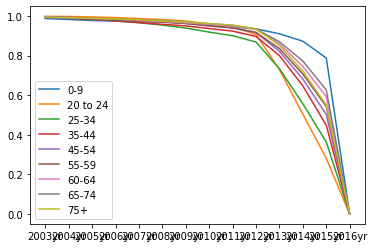

In [638]:

plt.plot(year_info.columns.values[1:],year_info.iloc[0,1:year_info.shape[1]], label = '0-9')
plt.plot(year_info.columns.values[1:],year_info.iloc[2,1:year_info.shape[1]], label = '20 to 24')
plt.plot(year_info.columns.values[1:],year_info.iloc[3,1:year_info.shape[1]], label = '25-34')
plt.plot(year_info.columns.values[1:],year_info.iloc[4,1:year_info.shape[1]], label = '35-44')
plt.plot(year_info.columns.values[1:],year_info.iloc[5,1:year_info.shape[1]], label = '45-54')
plt.plot(year_info.columns.values[1:],year_info.iloc[6,1:year_info.shape[1]], label ='55-59')
plt.plot(year_info.columns.values[1:],year_info.iloc[7,1:year_info.shape[1]], label ='60-64')
plt.plot(year_info.columns.values[1:],year_info.iloc[8,1:year_info.shape[1]], label ='65-74')
plt.plot(year_info.columns.values[1:],year_info.iloc[9,1:year_info.shape[1]], label ='75+')
plt.legend(loc='lower left')


In [639]:
year_info_trans = year_info.transpose()
year_info_trans.columns = year_info_trans.iloc[0]
year_info_trans.drop(year_info_trans.index[0], inplace = True)
year_info_trans

Age,0 to 9 years,10 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 years and over
2003yr,0.987531,0.998577,0.998953,0.996069,0.993725,0.997001,0.994197,0.994403,0.993548,0.994706
2004yr,0.982544,0.998103,0.997732,0.991508,0.988796,0.993783,0.99018,0.991227,0.99114,0.991659
2005yr,0.977556,0.99668,0.995638,0.983488,0.982185,0.989394,0.983931,0.987445,0.987866,0.989252
2006yr,0.975062,0.995732,0.992148,0.974996,0.975238,0.985006,0.978277,0.983815,0.984014,0.985884
2007yr,0.972569,0.993123,0.987437,0.96619,0.966835,0.97974,0.97426,0.977613,0.981221,0.981713
2008yr,0.970075,0.989803,0.982028,0.954238,0.958319,0.974912,0.969052,0.972168,0.976213,0.975457
2009yr,0.962594,0.983401,0.974525,0.939299,0.950252,0.967671,0.962208,0.965966,0.969857,0.969362
2010yr,0.952618,0.976998,0.960216,0.918855,0.936807,0.953774,0.94971,0.958554,0.961479,0.961662
2011yr,0.945137,0.965853,0.944687,0.900613,0.923922,0.940974,0.939295,0.949024,0.953486,0.954283
2012yr,0.935162,0.944273,0.907521,0.86869,0.896807,0.916837,0.917125,0.932537,0.9349,0.934552


In [640]:
year_info_trans.mean().sort_values()

Age
25 to 34 years       0.796329
20 to 24 years       0.804011
35 to 44 years       0.819176
45 to 54 years       0.836078
10 to 19 years       0.837579
55 to 59 years       0.838821
75 years and over    0.847312
60 to 64 years       0.850811
65 to 74 years       0.857370
0 to 9 years         0.873709
dtype: float64

In [641]:
patron_df = pd.DataFrame(np.array(df.groupby('Patron_Type_Definition').Patron_Type_Definition.count().index), columns= ["Patron_Type_Definition"])
patron_df
   

,Patron_Type_Definition
0,ADULT
1,AT USER ADULT
2,AT USER JUVENILE
3,AT USER SENIOR
4,AT USER TEEN
5,AT USER WELCOME
6,BOOKS BY MAIL
7,DIGITAL ACCESS CARD
8,FRIENDS FOR LIFE
9,JUVENILE


In [642]:
library_df = pd.DataFrame(np.array(df.groupby('Home_Library_Definition').Home_Library_Definition.count().index), columns= ["Home_Library_Definition"])
library_df
   

,Home_Library_Definition
0,Anza
1,Bayview/Linda Brooks-Burton
2,Bernal Heights
3,Branch Bookmobile (Excelsior)
4,Branch Bookmobile (Marina)
5,Branch Bookmobile (Sunset)
6,Branch Bookmobile (West Portal)
7,Children's Bookmobile
8,Chinatown
9,Eureka Valley/Harvey Milk Memorial


,Library,District
0,Parkside,4
1,Ortega,4
2,Richmond,1
3,Anza,1
4,Park,5
5,Presidio,2
6,Western Edition,2
7,Golden Gate Valley,2
8,Marina,2
9,Chinatown,3


In [ ]:
df_w_dist = df.join( district_df, on = "")

In [643]:
def ret_data_calc(start_df,group_data,data_select,start_year,end_year):
    for j in range(start_year,end_year+1):
        next_year = j +1 
        yr=[]
        for i in group_data[data_select]:
            yr.append((start_df[(start_df.Circulation_Active_Year >= next_year) & (start_df.Year_Patron_Registered == start_year) & (start_df.Total_Checkouts >0) & (start_df[data_select] == str(i))].Total_Renewals.count())/(start_df[(start_df.Year_Patron_Registered == start_year) & (start_df[data_select] == str(i))].Total_Renewals.count()))
        group_data[str(j)+'yr'] = yr
    return group_data

In [644]:
library_info = ret_data_calc(df,library_df,"Home_Library_Definition",2003,2016)

In [645]:
library_info

,Home_Library_Definition,2003yr,2004yr,2005yr,2006yr,2007yr,2008yr,2009yr,2010yr,2011yr,2012yr,2013yr,2014yr,2015yr,2016yr
0,Anza,0.995692,0.994462,0.989538,0.987077,0.983385,0.976000,0.968615,0.959385,0.950154,0.922462,0.843077,0.699077,0.519385,0.0
1,Bayview/Linda Brooks-Burton,0.986486,0.980480,0.974474,0.960961,0.947447,0.938438,0.914414,0.896396,0.879880,0.855856,0.710210,0.525526,0.310811,0.0
2,Bernal Heights,0.996203,0.992405,0.987975,0.983544,0.977215,0.972152,0.968987,0.955696,0.945570,0.931013,0.836076,0.706962,0.546835,0.0
3,Branch Bookmobile (Excelsior),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.857143,0.857143,0.714286,0.571429,0.0
4,Branch Bookmobile (Marina),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
5,Branch Bookmobile (Sunset),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000,0.750000,0.750000,0.625000,0.0
6,Branch Bookmobile (West Portal),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.777778,0.666667,0.0
7,Children's Bookmobile,1.000000,1.000000,1.000000,0.963415,0.951220,0.926829,0.914634,0.914634,0.902439,0.878049,0.768293,0.597561,0.378049,0.0
8,Chinatown,0.997197,0.993316,0.990082,0.986632,0.982751,0.977145,0.970030,0.957309,0.945019,0.921949,0.807676,0.642303,0.441570,0.0
9,Eureka Valley/Harvey Milk Memorial,0.998223,0.998223,0.995853,0.993483,0.989336,0.986967,0.984597,0.980450,0.969787,0.949052,0.876777,0.774882,0.623223,0.0


In [646]:
library_info_trans = library_info.transpose()
library_info_trans.columns = library_info_trans.iloc[0]
library_info_trans.drop(library_info_trans.index[0], inplace = True)
library_info_trans

Home_Library_Definition,Anza,Bayview/Linda Brooks-Burton,Bernal Heights,Branch Bookmobile (Excelsior),Branch Bookmobile (Marina),Branch Bookmobile (Sunset),Branch Bookmobile (West Portal),Children's Bookmobile,Chinatown,Eureka Valley/Harvey Milk Memorial,...,Parkside,Portola,Potrero,Presidio,Richmond,Sunset,Unknown,Visitacion Valley,West Portal,Western Addition
2003yr,0.995692,0.986486,0.996203,1,1,1,1,1,0.997197,0.998223,...,0.998606,0.997878,0.994949,0.995074,0.99809,0.99795,1,0.993873,0.998859,0.996146
2004yr,0.994462,0.98048,0.992405,1,1,1,1,1,0.993316,0.998223,...,0.994888,0.996464,0.992929,0.992611,0.995544,0.996193,1,0.988971,0.997719,0.992935
2005yr,0.989538,0.974474,0.987975,1,1,1,1,1,0.990082,0.995853,...,0.9921,0.994342,0.985859,0.989327,0.991301,0.992972,0.993151,0.984069,0.995723,0.990366
2006yr,0.987077,0.960961,0.983544,1,1,1,1,0.963415,0.986632,0.993483,...,0.987918,0.988685,0.977778,0.986864,0.986845,0.989458,0.993151,0.976716,0.993442,0.987797
2007yr,0.983385,0.947447,0.977215,1,1,1,1,0.95122,0.982751,0.989336,...,0.985595,0.98232,0.972727,0.981938,0.983662,0.98653,0.993151,0.973039,0.989735,0.979448
2008yr,0.976,0.938438,0.972152,1,1,1,1,0.926829,0.977145,0.986967,...,0.980483,0.975955,0.967677,0.979475,0.981328,0.983602,0.986301,0.966912,0.985458,0.975594
2009yr,0.968615,0.914414,0.968987,1,1,1,1,0.914634,0.97003,0.984597,...,0.973978,0.96959,0.965657,0.968801,0.97666,0.977745,0.972603,0.957108,0.978899,0.968529
2010yr,0.959385,0.896396,0.955696,1,1,1,1,0.914634,0.957309,0.98045,...,0.967007,0.958982,0.958586,0.957307,0.967112,0.967789,0.952055,0.946078,0.967779,0.96018
2011yr,0.950154,0.87988,0.94557,0.857143,1,1,1,0.902439,0.945019,0.969787,...,0.959572,0.945545,0.951515,0.948276,0.958413,0.95959,0.931507,0.931373,0.956943,0.949261
2012yr,0.922462,0.855856,0.931013,0.857143,1,0.875,1,0.878049,0.921949,0.949052,...,0.930297,0.923621,0.931313,0.933498,0.937195,0.939092,0.90411,0.89951,0.935272,0.929994


In [647]:
library_info_trans.mean().sort_values()

Home_Library_Definition
Bayview/Linda Brooks-Burton           0.777242
Children's Bookmobile                 0.799652
Main Library                          0.810808
Visitacion Valley                     0.817314
Mission                               0.821534
Ocean View                            0.822680
Excelsior                             0.823102
Portola                               0.828602
Chinatown                             0.829499
Marina                                0.836576
Merced                                0.841890
Anza                                  0.842022
Western Addition                      0.842738
Ortega                                0.842796
Bernal Heights                        0.842902
Parkside                              0.842937
Presidio                              0.843010
Unknown                               0.843444
Potrero                               0.845238
North Beach                           0.845537
Branch Bookmobile (Excelsior)       

In [648]:
df[df["Home_Library_Definition"] == "Branch Bookmobile (West Portal)" ]

,Patron_Type_Definition,Total_Checkouts,Total_Renewals,Age_Range,Home_Library_Definition,Circulation_Active_Month,Circulation_Active_Year,Notice_Preference_Definition,Provided_Email_Address,Year_Patron_Registered,Outside_of_County,Renewal_Rate
5602,ADULT,19,1,25 to 34 years,Branch Bookmobile (West Portal),April,2014,email,True,2010,False,0.052632
9720,ADULT,6,0,20 to 24 years,Branch Bookmobile (West Portal),November,2014,email,True,2014,True,0.000000
17105,ADULT,31,0,25 to 34 years,Branch Bookmobile (West Portal),April,2014,print,False,2004,False,0.000000
21575,ADULT,30,26,45 to 54 years,Branch Bookmobile (West Portal),December,2015,email,True,2011,False,0.866667
22029,ADULT,407,111,20 to 24 years,Branch Bookmobile (West Portal),May,2016,email,True,2008,False,0.272727
25069,ADULT,148,27,20 to 24 years,Branch Bookmobile (West Portal),September,2014,email,True,2010,False,0.182432
27003,ADULT,679,39,20 to 24 years,Branch Bookmobile (West Portal),June,2016,email,True,2012,False,0.057437
27084,ADULT,253,58,35 to 44 years,Branch Bookmobile (West Portal),April,2016,email,True,2008,False,0.229249
34871,ADULT,10,3,20 to 24 years,Branch Bookmobile (West Portal),December,2013,email,True,2010,False,0.300000
37168,ADULT,39,23,25 to 34 years,Branch Bookmobile (West Portal),November,2014,email,True,2003,False,0.589744


In [ ]:
#based on your age and home library what is your average renewal rate? 
#this would be interesting because we could extend your checkout time base on the renewal rate
# other patrons who are waiting on a book from you on hold will get a better estimate of wait time

In [652]:

new_df['Library'] = df['Home_Library_Definition']
new_df['Renewal_Rate'] = df['Renewal_Rate']
new_df['Age_Range'] = df['Age_Range']
new_df.head()

,Library,Renewal_Rate,Age_Range
0,Main Library,0.464286,65 to 74 years
1,Main Library,0.476190,55 to 59 years
2,Main Library,2.032727,60 to 64 years
3,Mission Bay,0.520548,45 to 54 years
4,Main Library,0.494505,45 to 54 years


In [669]:
new_df.Renewal_Rate.isnull().sum()

73578

In [683]:
new_df = new_df.dropna(subset = ['Age_Range'], axis = 0)
  

In [684]:
new_df_w_dummy = create_dummy_df(new_df,['Library'],True)

In [685]:
new_df_w_dummy.head()

,Renewal_Rate,Age_Range,Library__Bayview/Linda Brooks-Burton,Library__Bernal Heights,Library__Branch Bookmobile (Excelsior),Library__Branch Bookmobile (Marina),Library__Branch Bookmobile (Sunset),Library__Branch Bookmobile (West Portal),Library__Children's Bookmobile,Library__Chinatown,...,Library__Portola,Library__Potrero,Library__Presidio,Library__Richmond,Library__Sunset,Library__Unknown,Library__Visitacion Valley,Library__West Portal,Library__Western Addition,Library__nan
0,0.464286,65 to 74 years,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.476190,55 to 59 years,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.032727,60 to 64 years,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.520548,45 to 54 years,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.494505,45 to 54 years,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [686]:
new_df_w_dummy.Renewal_Rate.fillna(new_df_w_dummy.Renewal_Rate.mean(), inplace = True)

    

In [687]:
new_df_w_dummy.isna().sum()

Renewal_Rate                                   0
Age_Range                                      0
Library__Bayview/Linda Brooks-Burton           0
Library__Bernal Heights                        0
Library__Branch Bookmobile (Excelsior)         0
Library__Branch Bookmobile (Marina)            0
Library__Branch Bookmobile (Sunset)            0
Library__Branch Bookmobile (West Portal)       0
Library__Children's Bookmobile                 0
Library__Chinatown                             0
Library__Eureka Valley/Harvey Milk Memorial    0
Library__Excelsior                             0
Library__Glen Park                             0
Library__Golden Gate Valley                    0
Library__Ingleside                             0
Library__Library on Wheels                     0
Library__Main Library                          0
Library__Marina                                0
Library__Merced                                0
Library__Mission                               0
Library__Mission Bay

In [688]:
    X = new_df_w_dummy.drop('Age_Range', axis=1)


In [689]:
    y = new_df_w_dummy['Age_Range']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)
  

In [690]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [691]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

     0 to 9 years       0.21      0.06      0.09     11302
   10 to 19 years       0.23      0.49      0.32     17659
   20 to 24 years       0.25      0.00      0.00      8966
   25 to 34 years       0.26      0.77      0.38     27290
   35 to 44 years       0.19      0.05      0.08     20220
   45 to 54 years       0.00      0.00      0.00     15928
   55 to 59 years       0.00      0.00      0.00      6422
   60 to 64 years       0.00      0.00      0.00      5879
   65 to 74 years       0.00      0.00      0.00      9029
75 years and over       0.42      0.02      0.05      4275

         accuracy                           0.25    126970
        macro avg       0.16      0.14      0.09    126970
     weighted avg       0.17      0.25      0.15    126970

